In [94]:
import numpy as np

loan_data = np.load("./balanced_loan_data.npy", allow_pickle=True)


In [95]:
loan_data.shape
loan_data[::5].shape
loan_data = loan_data[::5]
loan_data = loan_data[:17000]

In [96]:
import numpy as np

def calculate_log_likelihood(data, mu_k, sigma_k, pi_k):
    """
    Calculate the log-likelihood of data under a Gaussian Mixture Model.

    Parameters:
    - data: numpy array of shape (n_samples, n_features), the input data.
    - mu_k: numpy array of shape (n_components, n_features), the means of the components.
    - sigma_k: numpy array of shape (n_components, n_features, n_features), the covariance matrices.
    - pi_k: numpy array of shape (n_components,), the mixture weights. Assumes weights sum to 1.

    Returns:
    - log_likelihood: float, the log-likelihood of the entire dataset.
    """
    n_samples, n_features = data.shape
    n_components = mu_k.shape[0]

    # Initialize log-likelihood for all samples
    log_likelihood = 0.0

    for i in range(n_samples):
        sample_likelihood = 0.0

        for k in range(n_components):
            # Mean and covariance for component k
            mean = mu_k[k]
            cov = sigma_k[k]

            # Calculate the determinant and inverse of the covariance matrix
            det_cov = np.linalg.det(cov)
            inv_cov = np.linalg.inv(cov)

            # Gaussian PDF for component k
            norm_const = 1 / np.sqrt((2 * np.pi) ** n_features * det_cov)
            diff = data[i] - mean
            pdf_k = norm_const * np.exp(-0.5 * diff @ inv_cov @ diff)

            # Weighted PDF for component k
            sample_likelihood += pi_k[k] * pdf_k

        # Add log of sample likelihood to the total log-likelihood
        log_likelihood += np.log(sample_likelihood)

    return log_likelihood 


In [97]:
loan_data, loan_label, date = loan_data[:, :-2], loan_data[:, -2], loan_data[:, -1]

In [98]:
from sklearn.cluster import KMeans
import numpy as np



def initialize_parameters(
    n_components,
    n_features,
    first_points=None,
    method='random',
    random_state=None,
):
    # if random_state is not None:
    #     np.random.seed(random_state)

    # Step 1: Initialize mixing coefficients uniformly
    pi = np.ones(n_components) / n_components

    # Step 2: Initialize means
    if first_points is not None:
      if method == 'kmeans':
        #Use kmeans to initialize on a small batch, random initialization can lead to bad results
        kmeans = KMeans(n_clusters=n_components, init='k-means++', n_init=1, random_state=random_state)
        kmeans.fit(first_points)
        mu_k = kmeans.cluster_centers_
        #Add noise to mu_k
        mu_k = mu_k + np.random.randn(n_components, n_features) * 0.5
      elif method == 'random':
        # Random initialization based on the range observed from a small batch
        #init mu_k as an empty n_components,n_features shaped array
        mu_k = np.empty((n_components,n_features))
        for idx in range(n_features):
          mu_k[:,idx] = np.random.uniform(np.min(first_points[:,idx]), np.max(first_points[:,idx]), n_components)
    else:
        # Random initialization with large spread and mean 0
        mu_k = np.random.randn(n_components, n_features) * 5.0


    # Step 3: Initialize covariances with broad coverage
    # Use diagonal matrices with a slight spread for differentiation
    sigma_k = np.array([
        np.eye(n_features) * (2.0 + 0.5 * k)  # Increase spread slightly across components
        for k in range(n_components)
    ])

    return pi, mu_k, sigma_k



def compute_probabilities(x, pi, mu, sigma, eps=1e-15):
    K = len(pi)
    log_probabilities = np.zeros(K)

    for k in range(K):
        diff = x - mu[k]
        # Add small constant to diagonal for numerical stability
        sigma_k = sigma[k] + eps * np.eye(sigma[k].shape[0])

        # Compute log probability in a numerically stable way
        log_det = np.log(np.linalg.det(sigma_k))
        inv_sigma = np.linalg.inv(sigma_k)
        exponent = -0.5 * np.dot(diff.T, np.dot(inv_sigma, diff))
        log_probabilities[k] = np.log(pi[k]) + exponent - 0.5 * (log_det + len(x) * np.log(2 * np.pi))

    # Subtract maximum for numerical stability
    log_probabilities -= np.max(log_probabilities)
    probabilities = np.exp(log_probabilities)
    probabilities /= np.sum(probabilities)

    return probabilities

def compute_parameters(mu_stats, n_samples, reg_covar=1e-6, eps=1e-10):
    # Compute mixing coefficients with minimum probability
    pi = np.maximum(mu_stats['N'], eps)
    # pi = pi / np.sum(pi)
    pi = pi / n_samples

    # Compute means with safety check
    safe_N = np.maximum(mu_stats['N'], eps)[:, None]
    mu = mu_stats['sum_x'] / safe_N

    # Compute covariances
    sigma = []
    for k in range(len(pi)):
        safe_N_k = max(mu_stats['N'][k], eps)
        cov = mu_stats['sum_xx'][k] / safe_N_k - np.outer(mu[k], mu[k])
        # Ensure symmetry
        cov = (cov + cov.T) / 2
        # Add regularization to diagonal
        cov.flat[::len(cov) + 1] += reg_covar
        # Ensure positive definiteness
        min_eig = np.min(np.linalg.eigvals(cov))
        if min_eig < 0:
            cov.flat[::len(cov) + 1] -= min_eig - eps
        sigma.append(cov)

    return pi, mu, np.array(sigma)

def online_incremental_em_gmm(X, n_components=3, T=1, random_state=None, init_batch_size = 100, init_method = 'random'):
    n_samples, n_features = X.shape


    # Step 1: Random initialization (with kmeans on a small batch)

    pi, mu, sigma = initialize_parameters(n_components=n_components, n_features=n_features, random_state=random_state,first_points=X[:init_batch_size],method=init_method)

    mu_history = [mu.copy()]
    sigma_history = [sigma.copy()]

    # Step 2: sufficient statistics
    gamma = np.zeros((n_samples, n_components))
    gamma_x = np.zeros((n_samples, n_components, n_features))
    gamma_xx = np.zeros((n_samples, n_components, n_features, n_features))

    mu_stats = {'N': np.zeros(n_components),
                'sum_x': np.zeros((n_components, n_features)),
                'sum_xx': np.zeros((n_components, n_features, n_features))}

    log_likelihood_history = []
    # EM Iterations
    for t in range(T):
        for idx in range(n_samples):
            x_i = X[idx]
            
            log_likelihood_history.append(calculate_log_likelihood(x_i[None], mu, sigma, pi))
            gamma_prime = compute_probabilities(x_i, pi, mu, sigma)

            # Update sufficient statistics for point idx
            s_prime_i_gamma = gamma_prime  # Shape: (K,)
            s_prime_i_gamma_x = gamma_prime[:, None] * x_i  # Shape: (K, d)
            s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) for k in range(n_components)])  # Shape: (K, d, d)

            # Update global sufficient statistics µ
            mu_stats['N'] += s_prime_i_gamma - gamma[idx]  # Shape: (K,)
            mu_stats['sum_x'] += s_prime_i_gamma_x - gamma_x[idx]  # Shape: (K, d)
            mu_stats['sum_xx'] += s_prime_i_gamma_xx - gamma_xx[idx]  # Shape: (K, d, d)

            # Update s_i for data point idx
            gamma[idx] = s_prime_i_gamma
            gamma_x[idx] = s_prime_i_gamma_x
            gamma_xx[idx] = s_prime_i_gamma_xx

            #Save the historical means and covariance matrices
            pi_, mu_, sigma_ = compute_parameters(mu_stats.copy(), idx+1)
            mu_history.append(mu_.copy())
            sigma_history.append(sigma_.copy())

    # After all iterations, compute final parameters
    print("\nComputing final GMM parameters...")
    pi, mu_k, sigma_k = compute_parameters(mu_stats, idx+1)

    return pi, mu_k, sigma_k, mu_history, sigma_history, log_likelihood_history



In [99]:
# Run Online Incremental EM for the drifting gaussians
X = loan_data 
X = X.astype(float)
X = X[:-1000]

n_components = 2
T = 1
random_state = 42
pi, mu_k, sigma_k, history_mu, history_sigma, log_likelihood_history = online_incremental_em_gmm(X, n_components=n_components, T=T, random_state=random_state,init_method='kmeans',init_batch_size=50)
pi_iem, mu_k_iem, sigma_k_iem, history_mu_iem, history_sigma_iem = pi, mu_k, sigma_k, history_mu, history_sigma
log_likelihood_history_iem = log_likelihood_history



Computing final GMM parameters...


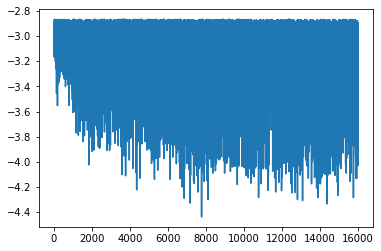

In [100]:
# plot the log likelihood history
import matplotlib.pyplot as plt
plt.plot(log_likelihood_history_iem)

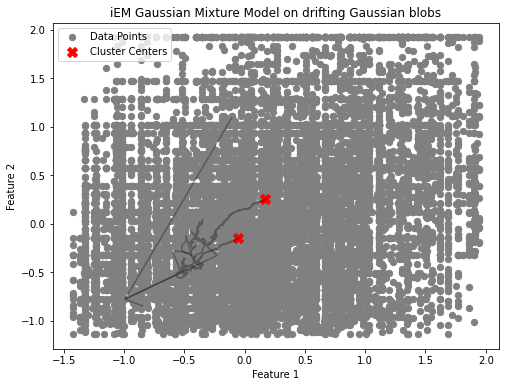

In [101]:
import matplotlib.pyplot as plt
# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='gray', s=40, label='Data Points')
history_mu_b = np.array(history_mu)
for k in range(n_components):
    plt.plot(history_mu_b[:, k, 0], history_mu_b[:, k, 1], 'k-', alpha=0.3)
plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
plt.title('iEM Gaussian Mixture Model on drifting Gaussian blobs')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [102]:

from scipy.stats import multivariate_normal
def initialize_parameters(n_components, n_features, first_points=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Initialize mixing coefficients
    pi = np.ones(n_components) / n_components
    
    # Initialize means with more spread
    if first_points is not None:
        mu_k = first_points + np.random.randn(n_components, n_features) * 2.0
    else:
        mu_k = np.random.randn(n_components, n_features) * 5.0
    
    # Initialize with larger covariances
    sigma_k = np.array([
        np.eye(n_features) * (2.0 + 0.5 * k) 
        for k in range(n_components)
    ])
    
    return pi, mu_k, sigma_k

def compute_responsibility(x_i, pi, mu_k, sigma_k):
    n_components = len(pi)
    probs = np.zeros(n_components)
    
    # Calculate squared distances to each center
    distances = np.array([np.sum((x_i - mu_k[k])**2) for k in range(n_components)])
    
    for k in range(n_components):
        try:
            probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
        except np.linalg.LinAlgError:
            sigma_k[k] = np.eye(len(x_i)) * np.trace(sigma_k[k]) / len(x_i)
            probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
    
    # Add small constant for numerical stability
    probs += 1e-10
    
    # Calculate initial responsibilities
    gamma = probs / probs.sum()
    
    # # Distance-based weighting
    # max_dist = np.max(distances)
    # distance_weights = 1.0 / (1.0 + distances/max_dist)
    # gamma = gamma * distance_weights
    # gamma = gamma / gamma.sum()

    gamma = gamma ** 2
    gamma = gamma / gamma.sum()
    
    # Ensure no component gets too dominant
    if np.max(gamma) > 0.9:
        gamma = np.clip(gamma, 0.1, 0.9)
        gamma = gamma / gamma.sum()
    
    return gamma
    

def update_parameters(x_i, gamma, pi, mu_k, sigma_k, N_k, step_size, t):
    n_components = len(pi)
    n_features = len(x_i)
    min_covar = 1e-6
    
    # Update counts with momentum
    N_k = (1 - step_size) * N_k + step_size * gamma
    
    # Update mixing coefficients
    pi = N_k / N_k.sum()
    
    # Calculate distances to current point
    distances = np.array([np.sum((x_i - mu_k[k])**2) for k in range(n_components)])
    max_dist = np.max(distances)
    
    # Update means with distance-weighted learning rates
    for k in range(n_components):
        delta = x_i - mu_k[k]
        
        # Distance-based learning rate adjustment
        distance_factor = 1.0 / (1.0 + distances[k]/max_dist)
        effective_rate = step_size * distance_factor
        
        # Only update if the responsibility is significant
        if gamma[k] > 0.1:
            mu_k[k] += effective_rate * gamma[k] * delta
    
    # Update covariances
    for k in range(n_components):
        delta = x_i - mu_k[k]
        delta_out = np.outer(delta, delta)
        
        # Use same distance-based learning rate
        distance_factor = 1.0 / (1.0 + distances[k]/max_dist)
        effective_rate = step_size * distance_factor
        
        if gamma[k] > 0.1:
            sigma_k[k] = (1 - effective_rate) * sigma_k[k] + \
                         effective_rate * gamma[k] * delta_out
            
            # Ensure positive definiteness
            sigma_k[k] = (sigma_k[k] + sigma_k[k].T) / 2
            eigvals, eigvecs = np.linalg.eigh(sigma_k[k])
            eigvals = np.maximum(eigvals, min_covar)
            sigma_k[k] = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    return pi, mu_k, sigma_k, N_k

# stepwise EM
def online_gmm(data_generator, n_components, n_features, n_iterations, alpha=0.6, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    # Collect first few points for initialization
    first_points = np.array([next(data_generator) for _ in range(n_components)])
    # first_points = None  # Disable initialization with first points

    # Initialize parameters
    pi, mu_k, sigma_k = initialize_parameters(n_components, n_features, first_points, random_state)
    N_k = np.ones(n_components) / n_components
    
    # Store history for visualization
    history_mu = []

    log_likelihood_history = []
    
    # Process data points one at a time
    for t in range(n_iterations):
        x_i = next(data_generator)
        
        # Adaptive step size with slower decay
        step_size = (t + 2) ** -alpha
        
        log_likelihood_history.append(calculate_log_likelihood(x_i[None], mu_k, sigma_k, pi))
        # E-step: Compute responsibilities
        gamma = compute_responsibility(x_i, pi, mu_k, sigma_k)
        
        # M-step: Update parameters
        pi, mu_k, sigma_k, N_k = update_parameters(x_i, gamma, pi, mu_k, sigma_k, N_k, step_size, t)
        
        # Store current means
        history_mu.append(mu_k.copy())
        
        if t % 50 == 0:
            if np.max(N_k) > 0.8 or np.min(N_k) < 0.2:
                # Reset mixing coefficients
                N_k = np.ones(n_components) / n_components
                pi = N_k.copy()
    
    return pi, mu_k, sigma_k, history_mu, log_likelihood_history

def data_generator(X):
    idx = 0
    n_samples = len(X)
    while idx < n_samples:
        yield X[idx]
        idx += 1


In [103]:
X = loan_data
X = X.astype(float)
X = X[:-1000]
n_components = 2
n_features = 2
n_samples = len(X)
alpha = 0.6
random_state = 42
n_iterations = n_samples - n_components

gen = data_generator(X)
pi, mu_k, sigma_k, history_mu, log_likelihood_histroy = online_gmm(gen, n_components, n_features, 
                                            n_iterations, alpha, random_state)

pi_step, mu_k_step, sigma_k_step, history_mu_step = pi, mu_k, sigma_k, history_mu
log_likelihood_histroy_step = log_likelihood_histroy

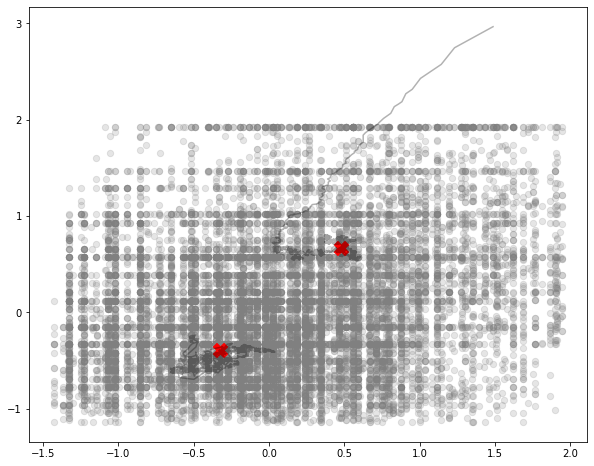

In [104]:
plt.figure(figsize=(10, 8))

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c='gray', s=40, alpha=0.2, label='Data Points')

# Plot final cluster centers
plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=200, marker='X', label='Final Centers')

# Plot center trajectories
history_mu = np.array(history_mu)
for k in range(n_components):
    plt.plot(history_mu[:, k, 0], history_mu[:, k, 1], 'k-', alpha=0.3)

In [105]:
from sklearn.mixture import GaussianMixture
X = loan_data
X = X.astype(float)
X = X[:-1000]

n_components = 2
gmm = GaussianMixture(n_components)
model = gmm.fit(X)
mu_k_gmm = model.means_
sigma_k_gmm = model.covariances_
pi_gmm = model.weights_


In [106]:
import numpy as np

def calculate_log_likelihood(data, mu_k, sigma_k, pi_k):
    """
    Calculate the log-likelihood of data under a Gaussian Mixture Model.

    Parameters:
    - data: numpy array of shape (n_samples, n_features), the input data.
    - mu_k: numpy array of shape (n_components, n_features), the means of the components.
    - sigma_k: numpy array of shape (n_components, n_features, n_features), the covariance matrices.
    - pi_k: numpy array of shape (n_components,), the mixture weights. Assumes weights sum to 1.

    Returns:
    - log_likelihood: float, the log-likelihood of the entire dataset.
    """
    n_samples, n_features = data.shape
    n_components = mu_k.shape[0]

    # Initialize log-likelihood for all samples
    log_likelihood = 0.0

    for i in range(n_samples):
        sample_likelihood = 0.0

        for k in range(n_components):
            # Mean and covariance for component k
            mean = mu_k[k]
            cov = sigma_k[k]

            # Calculate the determinant and inverse of the covariance matrix
            det_cov = np.linalg.det(cov)
            inv_cov = np.linalg.inv(cov)

            # Gaussian PDF for component k
            norm_const = 1 / np.sqrt((2 * np.pi) ** n_features * det_cov)
            diff = data[i] - mean
            pdf_k = norm_const * np.exp(-0.5 * diff @ inv_cov @ diff)

            # Weighted PDF for component k
            sample_likelihood += pi_k[k] * pdf_k

        # Add log of sample likelihood to the total log-likelihood
        log_likelihood += np.log(sample_likelihood)

    return log_likelihood 


In [107]:
loan_data = loan_data.astype(float)
likelihood_iem = calculate_log_likelihood(loan_data[-1000:], mu_k_iem, sigma_k_iem, pi_k=pi_iem)
likelihood_step = calculate_log_likelihood(loan_data[-1000:], mu_k_step, sigma_k_step, pi_k=pi_step)
likelihood_gmm = calculate_log_likelihood(loan_data[-1000:], mu_k_gmm, sigma_k_gmm, pi_k=pi_gmm)

print(f"Likelihood for Online Incremental EM: {likelihood_iem}")
print(f"Likelihood for Stepwise EM: {likelihood_step}")
print(f"Likelihood for GMM: {likelihood_gmm}")

Likelihood for Online Incremental EM: -2179.7219922792397
Likelihood for Stepwise EM: -2248.1111783176316
Likelihood for GMM: -2149.3311251775426


In [108]:
x = loan_data[0]
calculate_log_likelihood(x[None], mu_k_iem, sigma_k_iem, pi_k=pi_iem)

-2.571618552000545

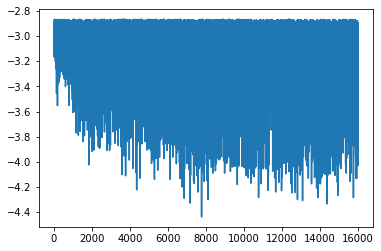

In [109]:
plt.plot(log_likelihood_history_iem, label='Online Incremental EM')

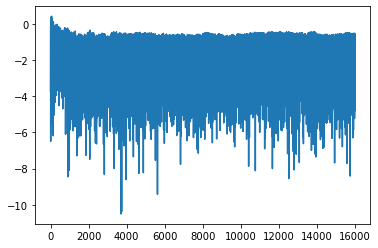

In [110]:
plt.plot(log_likelihood_histroy_step, label='Stepwise EM')

In [111]:
full_likelihood_gmm = calculate_log_likelihood(loan_data, mu_k_gmm, sigma_k_gmm, pi_k=pi_gmm)
full_likelihood_gmm = full_likelihood_gmm / len(loan_data)

In [147]:
len(log_likelihood_history_iem)
len(logl_loan_ssu)

16970

In [151]:
smoothed_iem.shape

(15401,)

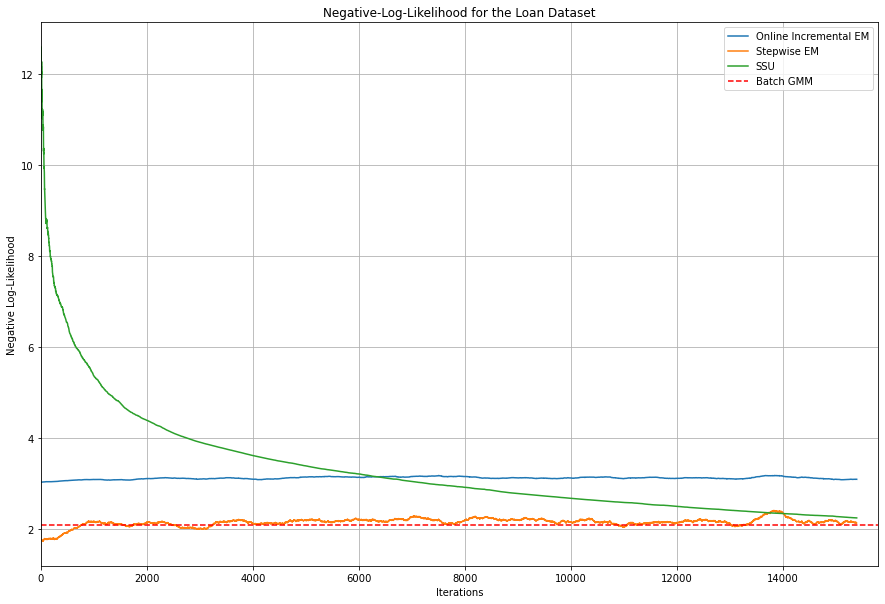

In [159]:
def smooth(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply smoothing
smoothed_iem = smooth(log_likelihood_history_iem[:], window_size=600)
smoothed_step = smooth(log_likelihood_histroy_step[:], window_size=600)

# Plot original and smoothed data
# plt.figure(figsize=(10, 6))
# bigger
plt.figure(figsize=(15, 10))

# Original data (optional: comment out if too noisy to display)
# plt.plot(log_likelihood_history_iem, alpha=0.3, label='Original Online Incremental EM', linestyle='dotted')
# plt.plot(log_likelihood_histroy_step, alpha=0.3, label='Original Stepwise EM', linestyle='dotted')

# Smoothed data
plt.plot(-smoothed_iem, label='Online Incremental EM')
plt.plot(-smoothed_step, label='Stepwise EM')
plt.plot(-logl_loan_ssu[:15401], label='SSU')
# plot a line for the GMM likelihood
plt.axhline(y=-full_likelihood_gmm, color='r', linestyle='--', label='Batch GMM')

# Add labels and legend
plt.xlabel('Iterations')
plt.ylabel('Negative Log-Likelihood')
# plt.ylim(1.5,7)   
plt.xlim(0, 15801)
plt.title('Negative-Log-Likelihood for the Loan Dataset')
plt.legend()
plt.grid(True)
plt.show()


In [118]:
import numpy as np
from scipy.stats import multivariate_normal
from tqdm import tqdm

def log_likelihood(means, method, data_so_far, underlying_data, covariance=None, iris_assignments=[], regularization_factor=1e-6):
  # given means for each time step
  # for iEM, sEM also given covariances
  # if not given covariance, need points seen so far to calc empirical covariance

  n_clusters = means.shape[0]

  #n_samples, n_features = data_so_far.shape
  n_samples, n_features = underlying_data.shape

  if method == 'SSU':

    distances = np.linalg.norm(data_so_far[:, None, :] - means[None, :, :], axis=2)
    if len(iris_assignments) > 0:
      cluster_assignments = np.argmin(distances, axis=1)
      cluster_assignments[-len(iris_assignments):] = iris_assignments  # Index of nearest cluster for each point
    else:
      cluster_assignments = np.argmin(distances, axis=1)


    cluster_covariances = []
    mixing_coefficients = []

    for k in range(n_clusters):
        points_in_cluster = data_so_far[cluster_assignments == k]



        n_k = points_in_cluster.shape[0]



        centered_points = points_in_cluster - means[k]
        covariance_matrix = np.dot(centered_points.T, centered_points) / (n_k)
        covariance_matrix += regularization_factor * np.eye(n_features)


        cluster_covariances.append(covariance_matrix)
        mixing_coefficients.append(n_k / n_samples)

    # Initialize array to store probabilities
    probabilities = np.zeros((n_samples, n_clusters))

    # Compute probabilities for each cluster
    for k in range(n_clusters):

        mvn = multivariate_normal(mean=means[k], cov=cluster_covariances[k])
        probabilities[:, k] = mixing_coefficients[k] * mvn.pdf(underlying_data)



    # Total likelihood for each data point
    total_likelihood = np.sum(probabilities, axis=1)

    # Compute the log-likelihood
    log_likelihood = np.sum(np.log(total_likelihood))

    return log_likelihood#, cluster_covariances

  elif method == 'iEM' or method == 'sEM':
        mixing_coefficients = np.full(n_clusters, 1 / n_clusters) #assume equal weighting due to lack of information
        probabilities = np.zeros((n_samples, n_clusters))

      # Calculate the empirical covariance matrix
        for k in range(n_clusters):

            covar = covariance[k] + 10e-3 * np.eye(n_features) # numerical instability
            #print(np.linalg.det(covar))
            mvn = multivariate_normal(mean=means[k], cov=covar)
            probabilities[:, k] = mixing_coefficients[k] * mvn.pdf(underlying_data)

            #print('greater than 1', np.where(probabilities[:, k] > 1)) still weird





        # Total likelihood for each data point
        total_likelihood = np.sum(probabilities, axis=1)


        # Compute the log-likelihood
        log_likelihood = np.sum(np.log(total_likelihood))


        return log_likelihood#, cluster_covariances



import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import qr
from scipy.sparse.csgraph import connected_components

# first defining initAlg from the paper

def initAlg(N_0, d, k, data, neighbors=3, init_limit=None, iris=False):

  def stream(data):
    for item in data:
      yield item

  input_stream = stream(data)

  c = 10

  rand_mat = np.random.randn(d,k)
  U = qr(rand_mat, mode='economic')[0]
  B = int(d*np.log(d))
  S = np.zeros((d,d))


  if N_0 < c*int(k*np.log(k)):
    #raise ValueError('Need N_0 > c*int(k*np.log(k))')
    print('hi')

  for p in range(N_0 - c*int(k*np.log(k))): # NEED N_0 > c*...
        if p % B == 0:
          U = qr(S @ U, mode='economic')[0]
          S = np.zeros((d,d))


        x_t = next(input_stream) #OTHER WAY TO DO THIS??

        S += x_t @ x_t.T
  #input_stream = stream(data) #cheeating a bit
  X_0 = []

  if init_limit == None:
    for i in range(c*int(k*np.log(k))):
        X_0.append(next(input_stream)) # CHECK
  else:
    for i in range(init_limit):
        X_0.append(next(input_stream))

  X_0_copy = np.array(X_0)

  X_0 = np.array(X_0).T

  Proj = U.T @ X_0


  nn_graph = kneighbors_graph(Proj.T, n_neighbors=neighbors, mode='connectivity', include_self=False)
  # visualization if we want
  #visualize_kneighbors_graph(nn_graph, Proj.T)

  n_comp, labels = connected_components(csgraph=nn_graph, directed=False, return_labels=True)



  centers = []
  for j in range(n_comp):
    cluster = Proj[:, labels == j]
    centers.append(np.mean(cluster, axis=1))

  centers = np.array(centers).T



  out = U @ centers

  if iris == False:
    ll = log_likelihood(out.T, 'SSU', X_0_copy, data) #could maybe change X_0_copy here
  else:
    ll=0

  return [out.T, ll, input_stream, X_0_copy] #CHECK





def streamSoftUpdate(N, N_0, d, k, data, neighbors=3, max_var=1, iris=False, init_limit=None):

    # max_sigma is max var of the true distributions
    def stream(data):
          for item in data:
              yield item

    data_stream = stream(data)

    eta = (3*np.log(N)) / N


    init = initAlg(N_0, d, k, data, neighbors=neighbors, iris=iris, init_limit=init_limit)

    means = init[0]

    data_stream = init[2] #test

    mean_sequence = [means]

    data_so_far = list(init[3])


    log_likelihoods = []
    assignments = []

    for t in tqdm(range(N)):
      try:
        x_t = next(data_stream)
        data_so_far.append(x_t)

        denom = 0
        for mu in means:
          denom += np.exp(-np.linalg.norm(x_t - mu)**2 / max_var)

        probs = []
        for mu in means:
          prob = np.exp(-np.linalg.norm(x_t - mu)**2 / max_var) / denom
          probs.append(prob)


        i_t = np.argmax(probs)

        assignments.append(i_t)


        means[i_t] = (1 - eta) * means[i_t] + eta * x_t

        mean_sequence.append(means.copy())

        if iris==False:
          ll = log_likelihood(means, 'SSU', np.array(data_so_far), data)
        else:
          ll = log_likelihood(means, 'SSU', np.array(data_so_far), data, iris_assignments=np.array(assignments))
        log_likelihoods.append(ll)
      except StopIteration:
        break



    return [means, mean_sequence, log_likelihoods]





In [121]:


# [centers, _, logl_iris_ssu] = streamSoftUpdate(len(iris.data), 30, 4, 5, np.array(iris.data), iris=True, neighbors=3, max_var=1)

# print(centers)

# plt.plot(logl_iris_ssu)
# for loan data

[centers, _, logl_loan_ssu] = streamSoftUpdate(len(loan_data), 30, 2, 2, np.array(loan_data), iris=False, neighbors=3, max_var=1)

100%|█████████▉| 16970/17000 [01:09<00:00, 244.40it/s]


In [125]:
logl_loan_ssu = np.array(logl_loan_ssu) / len(loan_data)

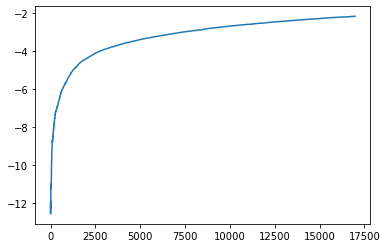

In [126]:
plt.plot(logl_loan_ssu)